In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load Data
df = pd.read_csv('/content/House Price India.csv')

# Data Hygiene: Drop ID and unrelated columns
# 'id' and 'Date' are metadata. 'Postal Code' is categorical but treated as numeric here, best to drop for regression.
data = df.drop(columns=['id', 'Date', 'Postal Code'])
print(df.describe())

# Separate Features (X) and Target (y)
X = data.drop(columns=['Price'])
y = data['Price']


# Split Data: 80% Training, 20% Testing (Fair Evaluation Strategy)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data (Crucial for Regularization later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Loaded and Split.")
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/House Price India.csv'

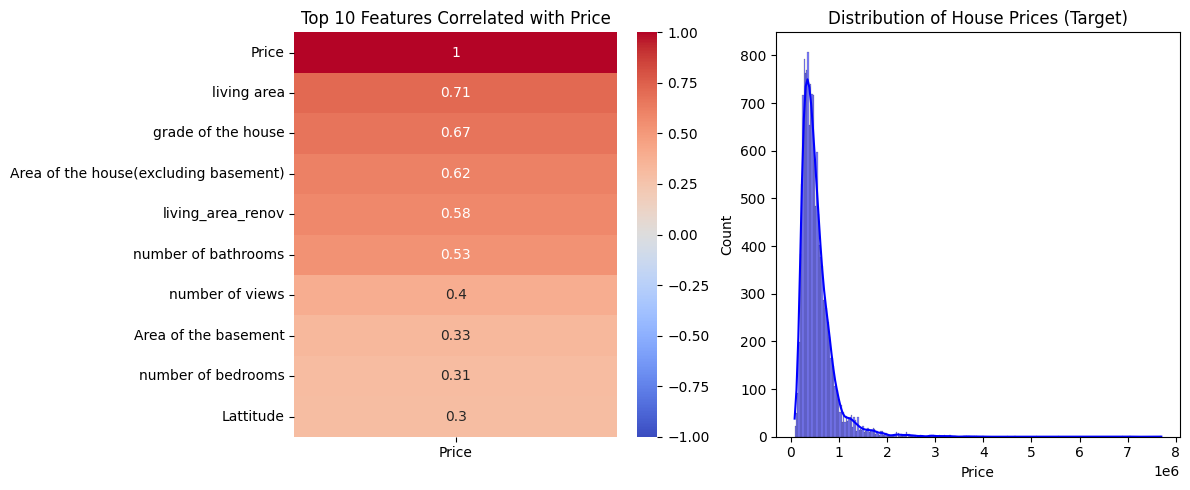

In [ ]:
plt.figure(figsize=(12, 5))

# Subplot 1: Correlation Heatmap (Top 10 features)
plt.subplot(1, 2, 1)
# Calculate correlations with Price
corr = data.corr()[['Price']].sort_values(by='Price', ascending=False).head(10)
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Top 10 Features Correlated with Price")

# Subplot 2: Price Distribution
plt.subplot(1, 2, 2)
sns.histplot(data['Price'], kde=True, color='blue')
plt.title("Distribution of House Prices (Target)")
plt.xlabel("Price")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> RMSE: {rmse:,.0f} | R2: {r2:.4f}")
    return rmse

# Baseline 1: Mean Prediction
y_pred_mean = np.full(len(y_test), y_train.mean())
evaluate(y_test, y_pred_mean, "Baseline (Mean)")

# Baseline 2: Median Prediction
y_pred_median = np.full(len(y_test), y_train.median())
evaluate(y_test, y_pred_median, "Baseline (Median)")

Baseline (Mean) -> RMSE: 375,436 | R2: -0.0002
Baseline (Median) -> RMSE: 386,867 | R2: -0.0621


np.float64(386867.038259615)

In [ ]:
# === SIMPLE LINEAR REGRESSION (SLR) ===
from sklearn.linear_model import LinearRegression

# Identify strongest correlation
correlation = data.corr()['Price'].drop('Price').abs()
top_feature = correlation.idxmax()
print(f"Strongest Predictor: {top_feature}")

# Train SLR
slr = LinearRegression()
slr.fit(X_train[[top_feature]], y_train)

# Evaluate
y_pred_slr = slr.predict(X_test[[top_feature]])
evaluate(y_test, y_pred_slr, f"SLR ({top_feature})");

Strongest Predictor: living area
SLR (living area) -> RMSE: 259,221 | R2: 0.5232


MLR (All Features) -> RMSE: 199,117 | R2: 0.7186


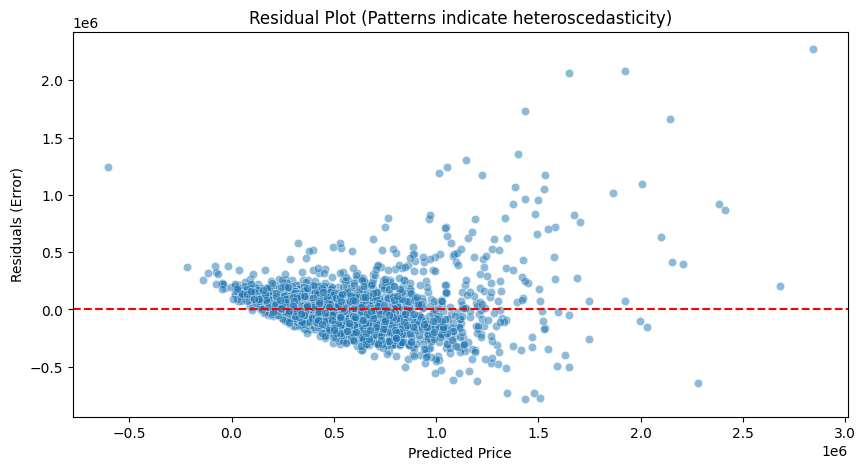

In [ ]:
# === MLR & RESIDUAL DIAGNOSTICS ===
# Train MLR
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred_mlr = mlr.predict(X_test)
evaluate(y_test, y_pred_mlr, "MLR (All Features)")

# Residual Analysis
residuals = y_test - y_pred_mlr
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred_mlr, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Patterns indicate heteroscedasticity)")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Error)")
plt.show()

In [ ]:
# === CHECK MULTICOLLINEARITY (VIF) ===
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Add constant for VIF calculation
X_with_const = sm.add_constant(X_train)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(len(X_with_const.columns))]

print("Top features with Infinite or High VIF (Redundant):")
print(vif_data.sort_values(by='VIF', ascending=False).head(5))
# Note: 'living area' usually has Inf VIF because it equals 'Area_house' + 'Area_basement'

Top features with Infinite or High VIF (Redundant):
                                  Feature           VIF
3                             living area           inf
10  Area of the house(excluding basement)           inf
11                   Area of the basement           inf
0                                   const  1.214580e+06
9                      grade of the house  3.418112e+00


In [ ]:
# === REGULARIZATION (RIDGE, LASSO, ELASTICNET) ===
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# Ridge (L2) - Handles Multicollinearity by shrinking
ridge = RidgeCV(cv=5).fit(X_train_scaled, y_train)
evaluate(y_test, ridge.predict(X_test_scaled), "Ridge")

# Lasso (L1) - Handles Multicollinearity by feature selection
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
evaluate(y_test, lasso.predict(X_test_scaled), "Lasso (Champion)")

# ElasticNet - Combination
enet = ElasticNetCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
evaluate(y_test, enet.predict(X_test_scaled), "ElasticNet")

print("\nChampion Model Selection: Lasso is chosen for its simplicity (Feature Selection) and high accuracy.")
print("Features Dropped by Lasso (Coeff ~ 0):")
coefs = pd.Series(lasso.coef_, index=X.columns)
print(coefs[coefs == 0].index.tolist())

Ridge -> RMSE: 199,116 | R2: 0.7187
Lasso (Champion) -> RMSE: 199,031 | R2: 0.7189
ElasticNet -> RMSE: 371,723 | R2: 0.0195

Champion Model Selection: Lasso is chosen for its simplicity (Feature Selection) and high accuracy.
Features Dropped by Lasso (Coeff ~ 0):
['number of floors', 'Area of the basement']


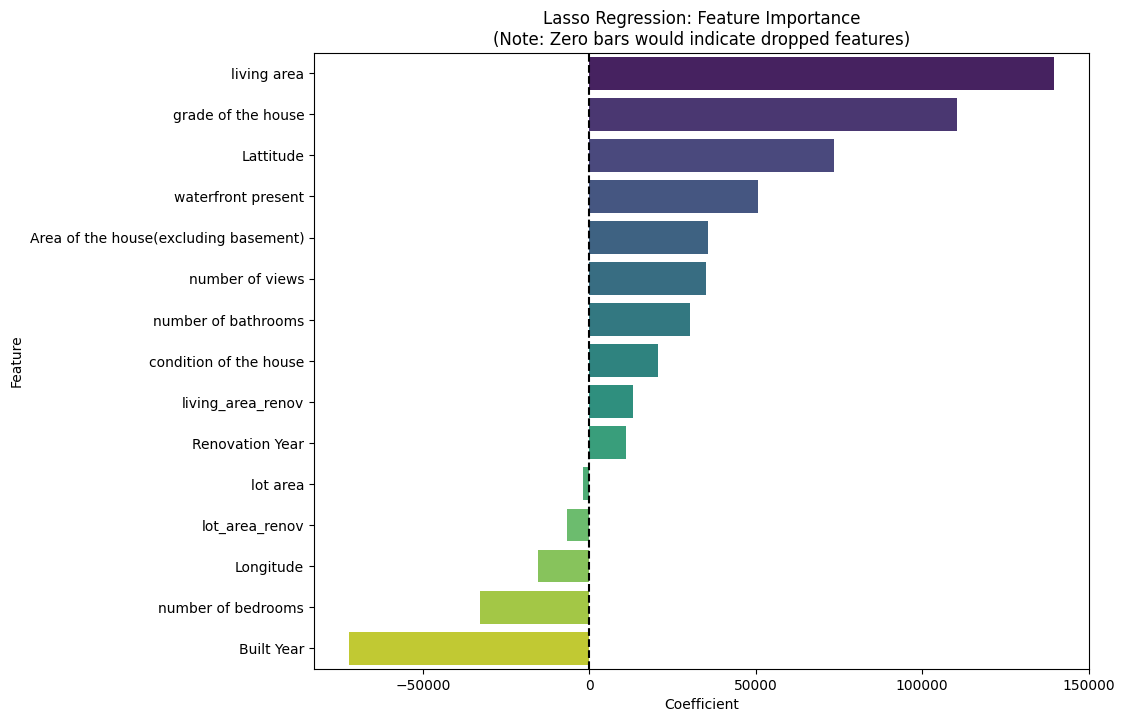

In [ ]:
# === LASSO FEATURE IMPORTANCE ===
# Get coefficients from the trained Lasso model
coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
}).sort_values(by='Coefficient', ascending=False)

# Filter to show only top 10 positive and top 5 negative features for clarity
top_coefs = pd.concat([coefs.head(10), coefs.tail(5)])

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=top_coefs, palette='viridis')
plt.title("Lasso Regression: Feature Importance\n(Note: Zero bars would indicate dropped features)")
plt.axvline(0, color='black', linestyle='--')
plt.show()

In [ ]:
# === EXPORT ARTIFACTS ===
import joblib
import json

# 1. Save Model
joblib.dump(lasso, 'champion_model.joblib')

# 2. Save Test Predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': lasso.predict(X_test_scaled)})
predictions.to_csv('houseprice_predictions_test.csv', index=False)

# 3. Save Metrics
final_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, predictions['Predicted'])),
    'R2': r2_score(y_test, predictions['Predicted'])
}
with open('test_metrics.json', 'w') as f:
    json.dump(final_metrics, f)

print("Success! Files saved: 'champion_model.joblib', 'houseprice_predictions_test.csv', 'test_metrics.json'")

Success! Files saved: 'champion_model.joblib', 'houseprice_predictions_test.csv', 'test_metrics.json'


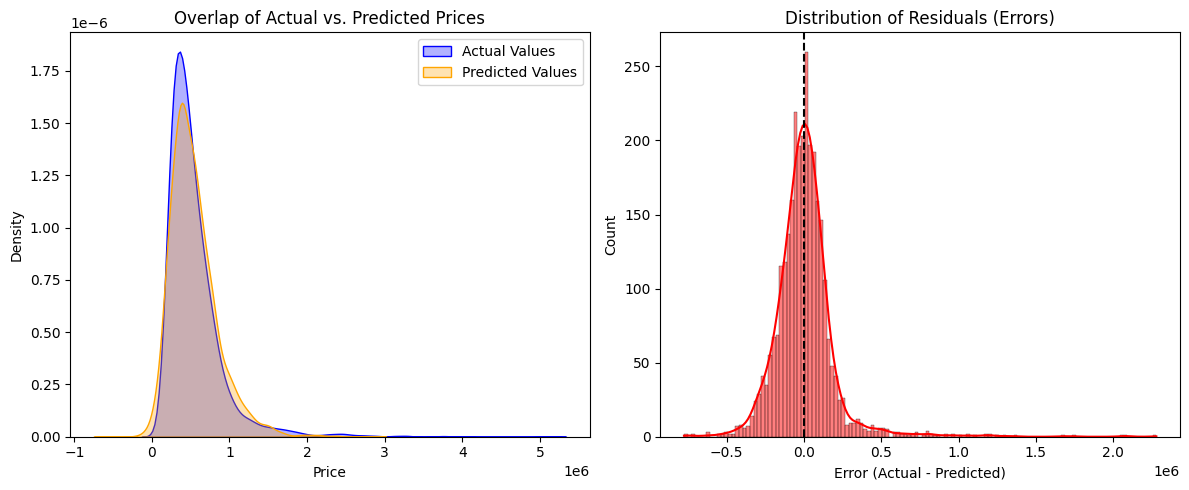

In [ ]:
# Calculate Residuals (Errors)
predictions = lasso.predict(X_test_scaled)
residuals = y_test - predictions

plt.figure(figsize=(12, 5))

# Plot 1: Actual vs Predicted Distribution
plt.subplot(1, 2, 1)
sns.kdeplot(y_test, label='Actual Values', color='blue', fill=True, alpha=0.3)
sns.kdeplot(predictions, label='Predicted Values', color='orange', fill=True, alpha=0.3)
plt.title("Overlap of Actual vs. Predicted Prices")
plt.legend()

# Plot 2: Residual Histogram
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='red')
plt.title("Distribution of Residuals (Errors)")
plt.xlabel("Error (Actual - Predicted)")
plt.axvline(0, color='black', linestyle='--') # Perfect prediction line

plt.tight_layout()
plt.show()